In [1]:
%load_ext autoreload
%autoreload 2
    
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import Button, HBox, VBox, Output
from IPython.display import display
import pickle 
from matplotlib.path import Path
from PIL import Image
import cv2

import glob
import os
import h5py

import torch
from torchvision import transforms, models
from PIL import Image
from sklearn.cluster import DBSCAN
import numpy as np
import shutil

from sklearn.decomposition import PCA

from utils import show_mirror

In [31]:
%reload_ext autoreload

In [2]:
with h5py.File("webcam_images.h5", "r") as f:
    for entry_name in f["images"]:
        entry = f["images"][entry_name]
        image = entry["image"][:]
        name = entry["image_name"][()].decode("utf-8")
        
        mirrors = []
        for mirror_name in entry["mirrors"]:
            mirrors.append(entry["mirrors"][mirror_name][:])

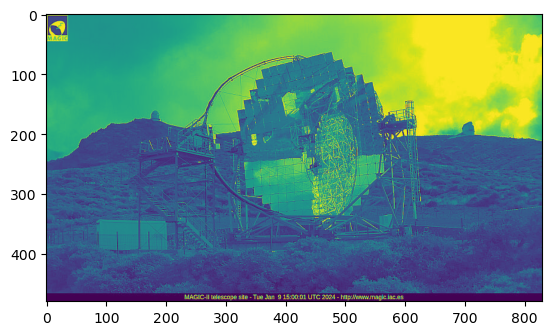

In [9]:
plt.imshow(image)

In [3]:
f = h5py.File("webcam_images.h5", "r")

In [4]:
WEBCAM_IMG_PATH = "/media/pgliwny/ADATA HD330/Computer_Vision_system/data/MAGIC/webcam/"
image_list = glob.glob(os.path.join(WEBCAM_IMG_PATH,"image_2024*"))
print(image_list[:3])

['/media/pgliwny/ADATA HD330/Computer_Vision_system/data/MAGIC/webcam/image_2024-01-09_1500.jpg', '/media/pgliwny/ADATA HD330/Computer_Vision_system/data/MAGIC/webcam/image_2024-02-01_1800.jpg', '/media/pgliwny/ADATA HD330/Computer_Vision_system/data/MAGIC/webcam/image_2024-02-25_1400.jpg']


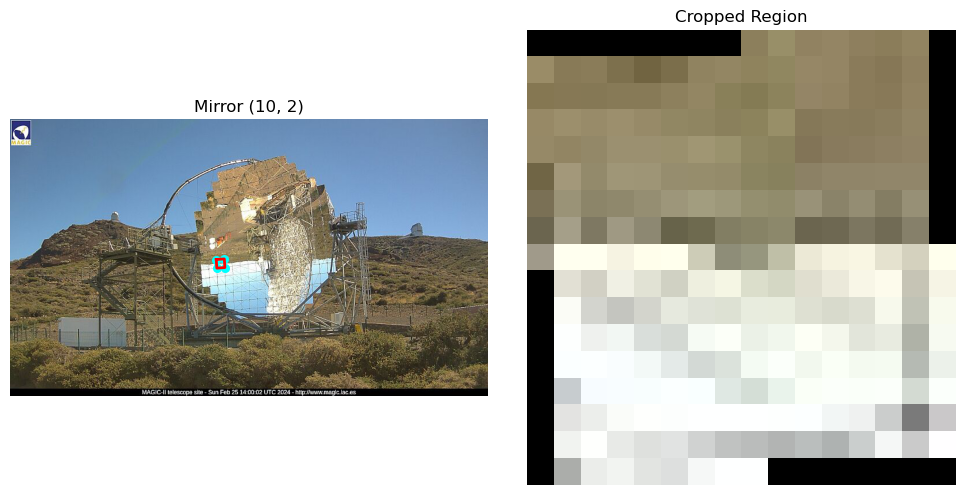

In [5]:
show_mirror(image_list[2], 172)

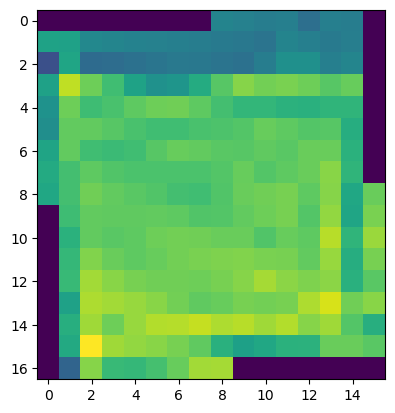

In [56]:
plt.imshow(f["images"]['entry_95']['mirrors']['mirror_172'][:])

# Clustering

In [6]:
feats = []
for entry_name in f["images"]:
    img_array = f["images"][entry_name]['mirrors']['mirror_172'][:].flatten()/255
    feats.append(img_array)

feats = np.stack(feats)

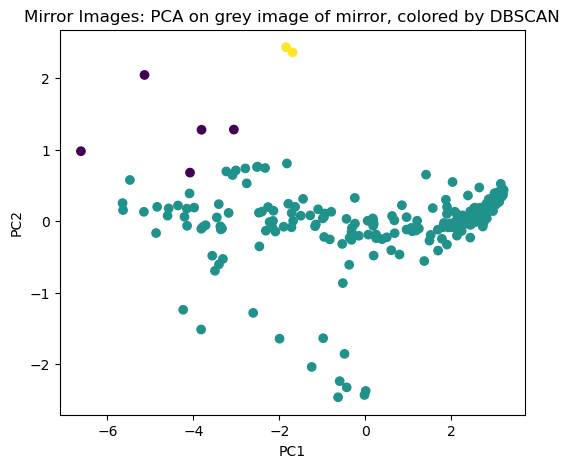

In [7]:
# 3. Reduce to 2D for plotting
pca = PCA(n_components=2)
proj = pca.fit_transform(feats)

# 4. Cluster with DBSCAN (eps/min_samples may need tuning)
clust = DBSCAN(eps=1.75, min_samples=2).fit(feats)
labels = clust.labels_  # -1 = anomaly, 0,1,2… = clusters

# 5. Scatter‐plot
plt.figure(figsize=(6,5))
plt.scatter(proj[:,0], proj[:,1], c=labels)
plt.title("Mirror Images: PCA on grey image of mirror, colored by DBSCAN")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [8]:
for label, entry_name in zip(labels, f["images"]):
    if label == -1:
        print(entry_name, label)

entry_127 -1
entry_128 -1
entry_129 -1
entry_130 -1
entry_136 -1


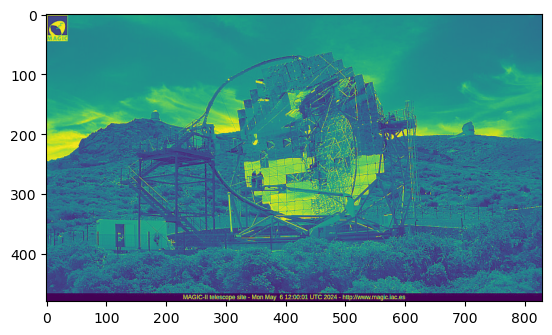

In [18]:
plt.imshow(f["images"]['entry_127']["image"][:])

In [13]:
name_bytes = f["images"]["entry_129"]["image_name"][()]  # odczytanie danych
image_name = name_bytes.decode("utf-8")  # dekodowanie bajtów do stringa
print("Image name:", image_name)

Image name: image_2024-05-08_1200.jpg
